# Fully Convolutional Watershed Distance Transform for 3D Data
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [ ]:
import os
import errno

import numpy as np

import sys
sys.path.insert(0,"/home/snn/deepcell-tf")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


import deepcell

In [3]:
import math
import numpy as np
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import callbacks
from tensorflow.python.keras.optimizers import SGD

from tensorflow.python.keras.utils.data_utils import get_file

from deepcell import losses
import image_gen as image_gen
from deepcell import image_generators
from deepcell import model_zoo
from deepcell.layers import TensorProduct, ReflectionPadding3D, DilatedMaxPool3D, ConvGRU2D

from deepcell.utils import train_utils
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.training import train_model_conv


from tensorflow.python.keras.layers import MaxPool3D
from tensorflow.python.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.python.keras.layers import Conv3D, ZeroPadding3D, ConvLSTM2D, Cropping3D
from tensorflow.python.keras.layers import Input, Add, Concatenate, Flatten, Reshape
from tensorflow.python.keras.engine.input_layer import InputLayer

from tensorflow.python.keras.models import Model


from tensorflow.python.keras.regularizers import l2
from deepcell.layers import ImageNormalization2D, ImageNormalization3D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Softmax

from sklearn.model_selection import train_test_split

from tensorflow.python.client import device_lib

ImportError: cannot import name 'ConvGRU2D'

### Load the Training Data

In [2]:
# If DATA_FILE exists just run this cell

from deepcell.utils.data_utils import get_data

DATA_DIR = '/data/npz_data/tracking_benchmark_data'
DATA_FILE = os.path.join(DATA_DIR, '3T3_HeLa_HEK_RAW_cropped.npz')
# DATA_FILE = os.path.join(DATA_DIR, '3T3_HeLa_HEK_RAW_V2_stacked.npz')

# Load Information for hardcoded image size training
seed = 1
test_size = .2
train_dict, test_dict = get_data(DATA_FILE, seed=seed, test_size=test_size)
X_train, y_train = train_dict['X'], train_dict['y']
X_test, y_test = test_dict['X'], test_dict['y']

print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))

NameError: name 'os' is not defined

### Set up filepath constants

In [4]:
# Set up other required filepaths
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)
ROOT_DIR = '/data' # mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

## Define feature net models

#### feature_net_3D is the gru analog of bn_feature_net_3D

In [81]:
def feature_net_3D(receptive_field=61,
                    n_frames=5,
                    input_shape=(5, 256, 256, 1),
                    n_features=3,
                    n_channels=1,
                    reg=1e-5,
                    n_conv_filters=64,
                    n_dense_filters=200,
                    VGG_mode=False,
                    init='he_normal',
                    norm_method='std',
                    location=False,
                    dilated=False,
                    padding=False,
                    padding_mode='reflect',
                    multires=False,
                    include_top=True,
                    temporal=None,
                    temporal_kernel_size=3):
    # Create layers list (x) to store all of the layers.
    # We need to use the functional API to enable the multiresolution mode
    x = []

    win = (receptive_field - 1) // 2
    
    if temporal == "conv":
        win_z = (n_frames - 1) // 2
    else:
        win_z = 0

    if dilated:
        padding = True

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
        time_axis = 2
        row_axis = 3
        col_axis = 4
        if not dilated:
            input_shape = (n_channels, n_frames, receptive_field, receptive_field)
    else:
        channel_axis = -1
        time_axis = 1
        row_axis = 2
        col_axis = 3
        if not dilated:
            input_shape = (n_frames, receptive_field, receptive_field, n_channels)

    x.append(Input(shape=input_shape))
    x.append(ImageNormalization3D(norm_method=norm_method,
                                  filter_size=receptive_field)(x[-1]))

    if padding:
        if padding_mode == 'reflect':
            x.append(ReflectionPadding3D(padding=(0, win, win))(x[-1]))
        elif padding_mode == 'zero':
            x.append(ZeroPadding3D(padding=(0, win, win))(x[-1]))

    if location:
        x.append(Location3D(in_shape=tuple(x[-1].shape.as_list()[1:]))(x[-1]))
        x.append(Concatenate(axis=channel_axis)([x[-2], x[-1]]))

    layers_to_concat = []

    rf_counter = receptive_field
    block_counter = 0
    d = 1

    while rf_counter > 4:
        filter_size = 3 if rf_counter % 2 == 0 else 4
        x.append(Conv3D(n_conv_filters, (1, filter_size, filter_size),
                        dilation_rate=(1, d, d), kernel_initializer=init,
                        padding='valid', kernel_regularizer=l2(reg))(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        x.append(Activation('relu')(x[-1]))

        block_counter += 1
        rf_counter -= filter_size - 1

        if block_counter % 2 == 0:
            if dilated:
                x.append(DilatedMaxPool3D(dilation_rate=(1, d, d),
                                          pool_size=(1, 2, 2))(x[-1]))
                d *= 2
            else:
                x.append(MaxPool3D(pool_size=(1, 2, 2))(x[-1]))

            if VGG_mode:
                n_conv_filters *= 2

            rf_counter = rf_counter // 2

            if multires:
                layers_to_concat.append(len(x) - 1)

    if multires:
        c = []
        for l in layers_to_concat:
            output_shape = x[l].get_shape().as_list()
            target_shape = x[-1].get_shape().as_list()
            time_crop = (0, 0)

            row_crop = int(output_shape[row_axis] - target_shape[row_axis])

            if row_crop % 2 == 0:
                row_crop = (row_crop // 2, row_crop // 2)
            else:
                row_crop = (row_crop // 2, row_crop // 2 + 1)

            col_crop = int(output_shape[col_axis] - target_shape[col_axis])

            if col_crop % 2 == 0:
                col_crop = (col_crop // 2, col_crop // 2)
            else:
                col_crop = (col_crop // 2, col_crop // 2 + 1)

            cropping = (time_crop, row_crop, col_crop)

            c.append(Cropping3D(cropping=cropping)(x[l]))
        x.append(Concatenate(axis=channel_axis)(c))

    x_prev_conv3d = Conv3D(n_dense_filters, (1, rf_counter, rf_counter),
                    dilation_rate=(1, d, d), kernel_initializer=init, activation='relu',
                    padding='valid', kernel_regularizer=l2(reg))(x[-1])
    x_prev_normed = BatchNormalization(axis=channel_axis)(x_prev_conv3d)
    
    print("x_prev_normed.output_shape", x_prev_normed.get_shape())
    
    x_prev_non_temporal = Conv3D(n_dense_filters, (1, 1, 1), dilation_rate=(1, d, d),
                        kernel_initializer=init, padding='valid', activation='relu',
                        kernel_regularizer=l2(reg))(x_prev_normed)
    
    print("x_prev_non_temporal.output_shape", x_prev_non_temporal.get_shape())
    print("temporal, ", temporal)
    if temporal == "conv":
        if padding:
            if padding_mode == 'reflect':
                padding = ReflectionPadding3D(padding=(win_z, 0, 0))(x_prev_non_temporal)
            elif padding_mode == 'zero':
                padding = ZeroPadding3D(padding=(win_z, 0, 0))(x_prev_non_temporal)
        residual = Conv3D(n_dense_filters, (n_frames, 1, 1), dilation_rate=(1, d, d),
                        kernel_initializer=init, padding='valid', activation='relu',
                        kernel_regularizer=l2(reg))(padding)
    elif temporal == "gru":
        residual = ConvGRU2D(filters=n_dense_filters, kernel_size=temporal_kernel_size,
                            padding='same', kernel_initializer=init, #activation='relu',
                            kernel_regularizer=l2(reg), return_sequences=True)(x_prev_non_temporal)
    elif temporal == "lstm":
        residual = ConvLSTM2D(filters=n_dense_filters, kernel_size=temporal_kernel_size,
                            padding='same', kernel_initializer=init, #activation='relu',
                            kernel_regularizer=l2(reg), return_sequences=True)(x_prev_non_temporal)
    
    residual_normed = BatchNormalization(axis=channel_axis)(residual)
    print("residual_normed.output_shape", residual_normed.get_shape())
    
    if temporal == None:
        x.append(x_prev_non_temporal)
    else:
        x.append(Add()([x_prev_non_temporal, residual_normed]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))

    x.append(TensorProduct(n_dense_filters, kernel_initializer=init,
                           kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

    x.append(TensorProduct(n_features, kernel_initializer=init,
                           kernel_regularizer=l2(reg))(x[-1]))

    if not dilated:
        x.append(Flatten()(x[-1]))

    if include_top:
        x.append(Softmax(axis=channel_axis)(x[-1]))

    model = Model(inputs=x[0], outputs=x[-1])
    model.summary()
    return model

#### feature_net_skip_3D is the gru analog of bn_feature_net_skip_3D

In [10]:
def feature_net_skip_3D(receptive_field=61,
                        input_shape=(5, 256, 256, 1),
                        fgbg_model=None,
                        temporal=None,
                        temporal_kernel_size=3,
                        last_only=True,
                        n_skips=1,
                        norm_method='whole_image',
                        padding_mode='reflect',
                        **kwargs):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    inputs = Input(shape=input_shape)
    img = ImageNormalization3D(norm_method=norm_method,
                               filter_size=receptive_field)(inputs)

    models = []
    model_outputs = []
    
    if fgbg_model is not None:
        for layer in fgbg_model.layers:
            layer.trainable = False
        models.append(fgbg_model)
        fgbg_output = fgbg_model(inputs)
        if isinstance(fgbg_output, list):
            fgbg_output = fgbg_output[-1]
        model_outputs.append(fgbg_output)

    for _ in range(n_skips + 1):
        if model_outputs:
            model_input = Concatenate(axis=channel_axis)([img, model_outputs[-1]])
        else:
            model_input = img

        new_input_shape = model_input.get_shape().as_list()[1:]
        models.append(feature_net_3D(receptive_field=receptive_field, 
                                     input_shape=new_input_shape, 
                                     norm_method=None, 
                                     dilated=True, 
                                     padding=True, 
                                     padding_mode=padding_mode, 
                                     temporal=temporal, 
                                     temporal_kernel_size=temporal_kernel_size, 
                                     **kwargs))
        model_outputs.append(models[-1](model_input))

    if last_only:
        model = Model(inputs=inputs, outputs=model_outputs[-1])
    elif fgbg_model is None:
        model = Model(inputs=inputs, outputs=model_outputs)
    else:
        model = Model(inputs=inputs, outputs=model_outputs[1:])
        
    model.summary()
    return model

#### Test Generator

In [7]:
DataGenerator = image_generators.MovieDataGenerator

datagen = DataGenerator(
    rotation_range=180,
    shear_range=False,
    zoom_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = DataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)


train_data = datagen.flow(
    train_dict,
    skip=3,
    seed=0,
    batch_size=1,
    transform='fgbg',
    transform_kwargs={},
    frames_per_batch=3)

val_data = datagen_val.flow(
    test_dict,
    skip=3,
    seed=0,
    batch_size=1,
    transform='fgbg',
    transform_kwargs={},
    frames_per_batch=3)

(642, 30, 135, 160, 1)
Image number: 456
Frame number: 8


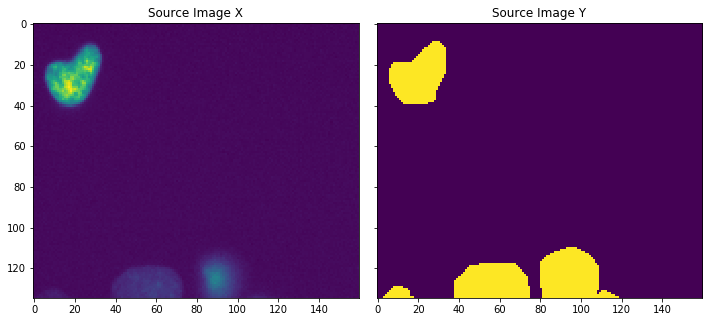

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

print(train_data.x.shape)

index = np.random.randint(low=0, high=train_data.x.shape[0])
frame = np.random.randint(low=0, high=train_data.x.shape[1])
print('Image number:', index)
print('Frame number:', frame)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(train_data.x[index, frame, ..., 0])
ax[0].set_title('Source Image X')

ax[1].imshow(train_data.y[index, frame, ..., 1])
ax[1].set_title('Source Image Y')

fig.tight_layout()
plt.show()

## Train the Model

### Training Parameters

In [112]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'trackingSEG_cropped_residual_lstm_fgbg_model_10e'
conv_model_name = 'trackingSEG_cropped_residual_lstm_watershed_model_10e'

n_epoch = 5  # Number of training epochs
norm_method = 'whole_image'  # data normalization - `whole_image` for 3d conv
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 0  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'watershed'
distance_bins = 4  # number of distance classes
erosion_width = 1  # erode edges, improves segmentation when cells are close

# 3D Settings
frames_per_batch = 3

# Temporal Settings
temporal = "lstm"
temporal_kernel_size = 3

### Foreground Background Model

#### (1) Instantiate the fgbg model

In [113]:
fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            temporal=temporal,
            temporal_kernel_size=temporal_kernel_size,
            input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
            last_only=False,
            norm_method=norm_method)

x_prev_normed.output_shape (?, 3, 135, 160, 128)
x_prev_non_temporal.output_shape (?, 3, 135, 160, 128)
temporal,  lstm
residual_normed.output_shape (?, 3, 135, 160, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_160 (InputLayer)          (None, 3, 135, 160,  0                                            
__________________________________________________________________________________________________
image_normalization3d_159 (Imag (None, 3, 135, 160,  0           input_160[0][0]                  
__________________________________________________________________________________________________
reflection_padding3d_100 (Refle (None, 3, 195, 220,  0           image_normalization3d_159[0][0]  
__________________________________________________________________________________________________
conv3d_649 (Conv3D)             (None

In [114]:
fgbg_model.load_weights('/data/models/trackingSEG_cropped_residual_lstm_fgbg_model_5e.h5')

#### (2) Train the fgbg model

In [115]:
from deepcell.training import train_model_conv

fgbg_model = train_model_conv(
        model=fgbg_model,
        train_dict=train_dict,
        test_dict=test_dict,
        model_name=fgbg_model_name,
        log_dir=LOG_DIR,
        transform='fgbg',
        optimizer=optimizer,
        batch_size=batch_size,
        frames_per_batch=frames_per_batch,
        n_epoch=n_epoch,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=(0.8, 1.2))

fgbg_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))
fgbg_model.save_weights(fgbg_weights_file)

X_train shape: (642, 30, 135, 160, 1)
y_train shape: (642, 30, 135, 160, 1)
X_test shape: (161, 30, 135, 160, 1)
y_test shape: (161, 30, 135, 160, 1)
Output Shape: (None, 3, 135, 160, 2)
Number of Classes: 2
Training on 1 GPUs
Epoch 1/5
641/642 [============================>.] - ETA: 0s - loss: 0.1074 - acc: 0.9640
Epoch 00001: val_loss improved from inf to 0.12619, saving model to /data/models/trackingSEG_cropped_residual_lstm_fgbg_model_10e.h5
642/642 [==============================] - 147s 230ms/step - loss: 0.1075 - acc: 0.9640 - val_loss: 0.1262 - val_acc: 0.9696
Epoch 2/5
641/642 [============================>.] - ETA: 0s - loss: 0.1082 - acc: 0.9639
Epoch 00002: val_loss improved from 0.12619 to 0.11998, saving model to /data/models/trackingSEG_cropped_residual_lstm_fgbg_model_10e.h5
642/642 [==============================] - 88s 137ms/step - loss: 0.1083 - acc: 0.9639 - val_loss: 0.1200 - val_acc: 0.9700
Epoch 3/5
641/642 [============================>.] - ETA: 0s - loss: 0.100

### Watershed energy transform

#### (1) Load weights for fgbg model if necessary

In [13]:
fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            temporal=temporal,
            temporal_kernel_size=temporal_kernel_size,
            input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
            last_only=False,
            )

fgbg_model.load_weights('/data/models/trackingSEG_cropped_non_temporal_fgbg_model_5e.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 3, 135, 160,  0                                            
__________________________________________________________________________________________________
image_normalization3d_15 (Image (None, 3, 135, 160,  0           input_16[0][0]                   
__________________________________________________________________________________________________
model_15 (Model)                (None, 3, 135, 160,  213570      image_normalization3d_15[0][0]   
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 3, 135, 160,  0           image_normalization3d_15[0][0]   
                                                                 model_15[1][0]                   
__________

#### (2) Instantiate the distance transform model 

In [116]:
watershed_model = feature_net_skip_3D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,  # (background edge, interior edge, cell interior, background)
    n_frames=frames_per_batch,
    n_conv_filters=32,
    n_dense_filters=128,
    temporal=temporal,
    temporal_kernel_size=temporal_kernel_size,
    multires=False,
    last_only=False,
    input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
    norm_method=norm_method)

x_prev_normed.output_shape (?, 3, 135, 160, 128)
x_prev_non_temporal.output_shape (?, 3, 135, 160, 128)
temporal,  lstm
residual_normed.output_shape (?, 3, 135, 160, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_162 (InputLayer)          (None, 3, 135, 160,  0                                            
__________________________________________________________________________________________________
image_normalization3d_161 (Imag (None, 3, 135, 160,  0           input_162[0][0]                  
__________________________________________________________________________________________________
reflection_padding3d_101 (Refle (None, 3, 195, 220,  0           image_normalization3d_161[0][0]  
__________________________________________________________________________________________________
conv3d_657 (Conv3D)             (None

In [117]:
watershed_model.load_weights('/data/models/trackingSEG_cropped_residual_lstm_watershed_model_5e.h5')

#### (3) Train the distance transform model

In [118]:
watershed_model = train_model_conv(
        model=watershed_model,
        train_dict=train_dict,
        test_dict=test_dict,
        model_name=conv_model_name,
        test_size=test_size,
        seed=seed,
        transform=transform,
        distance_bins=distance_bins,
        erosion_width=erosion_width,
        optimizer=optimizer,
        batch_size=batch_size,
        n_epoch=n_epoch,
        frames_per_batch=frames_per_batch,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=(0.8, 1.2))

watershed_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(conv_model_name))
watershed_model.save_weights(watershed_weights_file)

X_train shape: (642, 30, 135, 160, 1)
y_train shape: (642, 30, 135, 160, 1)
X_test shape: (161, 30, 135, 160, 1)
y_test shape: (161, 30, 135, 160, 1)
Output Shape: (None, 3, 135, 160, 4)
Number of Classes: 4
Training on 1 GPUs
Epoch 1/5
641/642 [============================>.] - ETA: 0s - loss: 0.6615 - acc: 0.8814
Epoch 00001: val_loss improved from inf to 0.62280, saving model to /data/models/trackingSEG_cropped_residual_lstm_watershed_model_10e.h5
642/642 [==============================] - 176s 275ms/step - loss: 0.6614 - acc: 0.8815 - val_loss: 0.6228 - val_acc: 0.8826
Epoch 2/5
641/642 [============================>.] - ETA: 0s - loss: 0.6461 - acc: 0.8842
Epoch 00002: val_loss improved from 0.62280 to 0.61900, saving model to /data/models/trackingSEG_cropped_residual_lstm_watershed_model_10e.h5
642/642 [==============================] - 120s 186ms/step - loss: 0.6462 - acc: 0.8841 - val_loss: 0.6190 - val_acc: 0.8662
Epoch 3/5
641/642 [============================>.] - ETA: 0s - 

# Run the model

#### Make predictions on test data

In [94]:
temporal = "conv"

raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
trks = load_trks(raw_trks_HEK)
lineages, X_test, y_test = trks['lineages'], trks['X'], trks['y']

run_fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            temporal=temporal,
            temporal_kernel_size=temporal_kernel_size,
            input_shape=tuple(X_test.shape[1:]),
            last_only=False,
            norm_method=norm_method)

run_fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_fgbg_model_5e.h5')

run_watershed_model = feature_net_skip_3D(
                        fgbg_model=run_fgbg_model,
                        receptive_field=receptive_field,
                        n_skips=n_skips,
                        n_features=distance_bins,
                        n_frames=frames_per_batch,
                        n_conv_filters=32,
                        n_dense_filters=128,
                        multires=False,
                        last_only=False,
                        input_shape=tuple(X_test.shape[1:]),
                        norm_method=norm_method,
                        temporal=temporal,
                        temporal_kernel_size=temporal_kernel_size)

run_watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_watershed_model_5e.h5')

temporal,  conv
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        (None, 30, 135, 160, 1)   0         
_________________________________________________________________
image_normalization3d_64 (Im (None, 30, 135, 160, 1)   0         
_________________________________________________________________
reflection_padding3d_28 (Ref (None, 34, 195, 220, 1)   0         
_________________________________________________________________
conv3d_252 (Conv3D)          (None, 34, 192, 217, 32)  544       
_________________________________________________________________
batch_normalization_288 (Bat (None, 34, 192, 217, 32)  128       
_________________________________________________________________
activation_284 (Activation)  (None, 34, 192, 217, 32)  0         
_________________________________________________________________
conv3d_253 (Conv3D)          (None, 34, 190, 215, 32)  9248 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_66 (InputLayer)           (None, 30, 135, 160, 0                                            
__________________________________________________________________________________________________
image_normalization3d_65 (Image (None, 30, 135, 160, 0           input_66[0][0]                   
__________________________________________________________________________________________________
model_64 (Model)                (None, 30, 135, 160, 213570      input_66[0][0]                   
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 30, 135, 160, 0           image_normalization3d_65[0][0]   
                                                                 model_64[1][0]                   
__________

In [95]:
# make predictions on testing data
test_images = run_watershed_model.predict(X_test[:1, :, :, :, :])# [-1]
test_images_fgbg = run_fgbg_model.predict(X_test[:1, :, :, :, :])# [-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (1, 30, 135, 160, 4)
segmentation mask shape: (1, 30, 135, 160, 2)


### Watershed post-processing

In [90]:
# Collapse predictions into semantic segmentation mask

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

watershed argmax shape: (1, 30, 135, 160, 1)


In [91]:
# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [92]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max
from skimage.segmentation import relabel_sequential
from skimage.measure import label, regionprops

watershed_images = []
perimeter_area_threshold = 2
foreground = argmax_images_post_fgbg > 0
small_objects_threshold = 100

n_movies = argmax_images_post_fgbg.shape[0]
n_frames = argmax_images_post_fgbg.shape[1]

for i in range(n_movies):
    watershed_frames = []
    for j in range(n_frames):
        image = fg_thresh[i,j,...,0]
        semantic = fg_thresh[i,j,...]
        distance = argmax_images_post_fgbg[i,j,...,0]
        
        markers = label(distance == 3)
        labels = watershed(-distance, markers, mask=image)
        watershed_frames.append(labels)
    watershed_images.append(np.stack(watershed_frames, axis=0))

watershed_images = np.stack(watershed_images, axis=0)
watershed_images = np.expand_dims(watershed_images, axis=-1)
# for i in range(argmax_images_post_fgbg.shape[0]):
#     image = fg_thresh[i, ..., 0]
#     semantic = fg_thresh[i]
#     distance = argmax_images_post_fgbg[i, ..., 0]

#     markers = label(distance == 3)
#     local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
#                                 exclude_border=False, indices=False, labels=image)

#     markers = label(local_maxi)
#     labels = watershed(-distance, markers, mask=image)
    
#     watershed_images.append(labels)
    

#     semantic_argmax = argmax_images[i]
    
#     watershed_sub_array = []
#     for i, segments_semantic in enumerate(segments):
#         masks_concat = image[i:i+1]
#         markers_semantic = markers[i]

#         # Remove misshapen watershed cells
#         props = regionprops(segments_semantic)
#         for prop in props:
#             if prop.perimeter ** 2 / prop.area > perimeter_area_threshold * 4 * np.pi:
#                 segments_semantic[segments_semantic == prop.label] = 0

#         masks_semantic = np.zeros((np.amax(segments_semantic).astype(int),
#                                    semantic.shape[1], semantic.shape[2]))
        
#         for j in range(0, masks_semantic.shape[0] + 1):
#             masks_semantic[j - 1] = segments_semantic == j
            
#         masks_concat = np.concatenate([masks_concat, masks_semantic], axis=0)
#         # print("masks_concat", masks_concat.shape)
#         label_image = np.sum(masks_concat, axis=0).astype(int)
#         # print("label_image", label_image.shape)
#         # Remove small objects
#         label_image = remove_small_objects(label_image, min_size=small_objects_threshold)
#         # Relabel the label image
#         label_image = label(label_image)
#         # print("label_image", label_image.shape)
#         watershed_sub_array.append(label_image)
#     watershed_images.append(watershed_sub_array)
        
# watershed_images = np.array(watershed_images)
# watershed_images = np.expand_dims(watershed_images, axis=-1)


### Plot the Results

Image number: 0
Frame: 24
(135, 160)


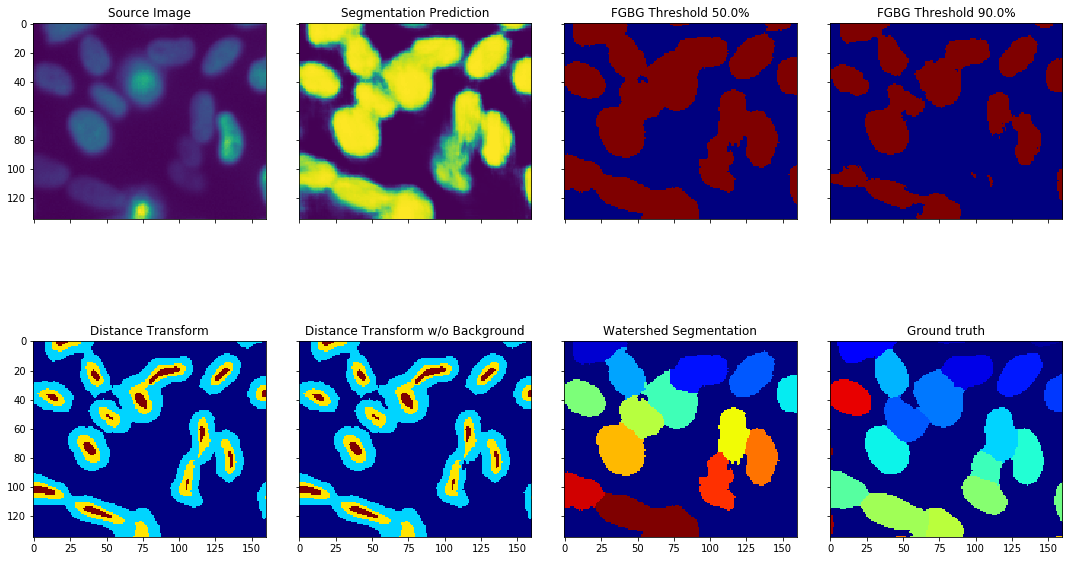

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

index = np.random.randint(low=0, high=1)
frame = np.random.randint(low=0, high=X_test.shape[1])
print('Image number:', index)
print('Frame:', frame)

print(markers.shape)

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

fg_thresh_90 = test_images_fgbg[..., 1] > 0.9
fg_thresh_90 = np.expand_dims(fg_thresh_90.astype('int16'), axis=-1)
ax[3].imshow(fg_thresh_90[index, frame, ..., 0], cmap='jet')
ax[3].set_title('FGBG Threshold {}%'.format(0.9 * 100))

ax[4].imshow(argmax_images[index, frame, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform')

ax[5].imshow(argmax_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Distance Transform w/o Background')

ax[6].imshow(watershed_images[index, frame, ..., 0], cmap='jet')
ax[6].set_title('Watershed Segmentation')

ax[7].imshow(y_test[index, frame, ..., 0], cmap='jet')
ax[7].set_title('Ground truth')

fig.tight_layout()
plt.show()
# plt.savefig('test.png')

### Run the Model Iteratively

In [86]:
# Define the Datasets

###### For Deepcell Datasets

# Define data to load (raw images from trk test files)
RAW_BASE_DIR = '/data/npz_data/tracking_benchmark_data/test'

raw_trks_3T3  = os.path.join(RAW_BASE_DIR, '3T3_NIH_test_BData.trks')
raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'HeLa_S3_test_BData.trks')
raw_trks_RAW  = os.path.join(RAW_BASE_DIR, 'RAW264_generic_test_BData.trks')

# raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_HeLa]
raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_HeLa, raw_trks_RAW]

# Define a base file name for the output
BASE_NAME = 'batch_'

In [119]:
# Make predictions on test data
from deepcell.utils.tracking_utils import load_trks
from skimage.morphology import remove_small_objects
import pandas as pd
from deepcell import metrics
from skimage.measure import label
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max

# CELL_TYPE_NAME = ['3T3', 'HEK293', 'HeLa']
CELL_TYPE_NAME = ['3T3', 'HEK293', 'HeLa', 'RAW264']
temporal = "lstm"
temporal_kernel_size = 3

perimeter_area_threshold = 2

# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.9
Lstats_AllDatasets = []

# Go through each Dataset (3T3, HEK293, HeLa, RAW264.7)
for set_num, dataset in enumerate(raw_trks_files):
    # Load the trk file       
    trks = load_trks(dataset)
    lineages, raw, tracked = trks['lineages'], trks['X'], trks['y']
    
    run_fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            temporal=temporal,
            temporal_kernel_size=temporal_kernel_size,
            input_shape=tuple(trks['X'].shape[1:]),
            last_only=False,
            norm_method=norm_method)

    run_fgbg_model.load_weights('/data/models/trackingSEG_cropped_residual_lstm_fgbg_model_10e.h5')

    run_watershed_model = feature_net_skip_3D(
                        fgbg_model=run_fgbg_model,
                        receptive_field=receptive_field,
                        n_skips=n_skips,
                        n_features=distance_bins,
                        n_frames=frames_per_batch,
                        n_conv_filters=32,
                        n_dense_filters=128,
                        multires=False,
                        last_only=False,
                        input_shape=tuple(trks['X'].shape[1:]),
                        norm_method=norm_method,
                        temporal=temporal,
                        temporal_kernel_size=temporal_kernel_size)

    run_watershed_model.load_weights('/data/models/trackingSEG_cropped_residual_lstm_watershed_model_10e.h5')
    
    Lstats_allmovies = []

    # Go through each batch (movie) in each dataset
    for batch_num, movie in enumerate(trks['X']):
        print("batch_num: ", batch_num)
        Lstats = []
        
        # Predict on the raw data
        X_test_temp = np.expand_dims(movie, axis=0)
        y_test_temp = np.expand_dims(trks['y'][batch_num], axis=0)
        print("X_test_temp.shape", X_test_temp.shape)
        test_images = run_watershed_model.predict(X_test_temp) #[-1]
        test_images_fgbg = run_fgbg_model.predict(X_test_temp) #[-1]
        # 
        # Postprocessing
        # Collapse predictions into semantic segmentation mask
        argmax_images = []
        for frame_num, frame in enumerate(test_images):
            max_image = np.argmax(frame, axis=-1)
            argmax_images.append(max_image)
        argmax_images = np.array(argmax_images)
        argmax_images = np.expand_dims(argmax_images, axis=-1)
        
        # threshold the foreground/background
        # and remove background from watershed transform
        fg_thresh = test_images_fgbg[..., 1] > threshold
        fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
        argmax_images_post_fgbg = argmax_images * fg_thresh
        watershed_images = []
        
        n_movies = argmax_images_post_fgbg.shape[0]
        n_frames = argmax_images_post_fgbg.shape[1]
        
        for i in range(n_movies):
            watershed_frames = []
            for j in range(n_frames):
                image = fg_thresh[i,j,...,0]
                semantic = fg_thresh[i,j,...]
                distance = argmax_images_post_fgbg[i,j,...,0]

                markers = label(distance == 3)
                labels = watershed(-distance, markers, mask=image)
                watershed_frames.append(labels)
            watershed_images.append(np.stack(watershed_frames, axis=0))

        watershed_images = np.stack(watershed_images, axis=0)
        watershed_images = np.expand_dims(watershed_images, axis=-1)

#         for i in range(argmax_images_post_fgbg.shape[0]):
#             image = fg_thresh[i, ..., 0]
#             semantic = fg_thresh[i]
#             distance = argmax_images_post_fgbg[i, ..., 0]

#             local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
#                                         exclude_border=False, indices=False, labels=image)

#             markers = label(local_maxi)
#             segments = watershed(-distance, markers, mask=image)


#             semantic_argmax = argmax_images[i]

#             watershed_sub_array = []
#             for i, segments_semantic in enumerate(segments):
#                 masks_concat = image[i:i+1]
#                 markers_semantic = markers[i]

#                 # Remove misshapen watershed cells
#                 props = regionprops(segments_semantic)
#                 for prop in props:
#                     if prop.perimeter ** 2 / prop.area > perimeter_area_threshold * 4 * np.pi:
#                         segments_semantic[segments_semantic == prop.label] = 0

#                 masks_semantic = np.zeros((np.amax(segments_semantic).astype(int),
#                                            semantic.shape[1], semantic.shape[2]))

#                 for j in range(0, masks_semantic.shape[0] + 1):
#                     masks_semantic[j - 1] = segments_semantic == j

#                 masks_concat = np.concatenate([masks_concat, masks_semantic], axis=0)
#                 # print("masks_concat", masks_concat.shape)
#                 label_image = np.sum(masks_concat, axis=0).astype(int)
#                 # print("label_image", label_image.shape)
#                 # Remove small objects
#                 label_image = remove_small_objects(label_image, min_size=small_objects_threshold)
#                 # Relabel the label image
#                 label_image = label(label_image)
#                 # print("label_image", label_image.shape)
#                 watershed_sub_array.append(label_image)
#             watershed_images.append(watershed_sub_array)
#         watershed_images = np.array(watershed_images)
#         watershed_images = np.expand_dims(watershed_images, axis=-1)
        
        print("watershed_images.shape", watershed_images.shape)
        print("y_test_temp.shape", y_test_temp.shape)
        
        # Remove small objects from GT for comparison
        small_objects_threshold=100
        for i in range(watershed_images.shape[0]):
            for j in range(watershed_images.shape[1]):
                # Remove small objects from GT for comparison
                GT_image = y_test_temp[i, j, :, :, :]
                watershed_image = watershed_images[i, j, :, :, :]
                GT_image = np.expand_dims(GT_image, axis=0)
                watershed_image = np.expand_dims(watershed_image, axis=0)
                GT_image = morphology.remove_small_objects(GT_image.astype('uint16'), min_size=small_objects_threshold)

                pp_watershed_image = morphology.remove_small_objects(
                                        watershed_image.astype('uint16'), 
                                        min_size=small_objects_threshold)

                # Accuracy from metrics package
                filename = CELL_TYPE_NAME[set_num] + BASE_NAME + '{}'.format(i)

                m = metrics.Metrics(model_name = filename)
                m.calc_object_stats(GT_image, pp_watershed_image)

                Lstats.append(m.stats)
            
        Lstats_allmovies.append(Lstats)
        
    Lstats_AllDatasets.append(Lstats_allmovies)

df_3T3    = pd.concat([pd.concat(Lstats_AllDatasets[0][i]) for i in range(len(Lstats_AllDatasets[0]))])
df_HEK293 = pd.concat([pd.concat(Lstats_AllDatasets[1][i]) for i in range(len(Lstats_AllDatasets[1]))])
df_HeLa   = pd.concat([pd.concat(Lstats_AllDatasets[2][i]) for i in range(len(Lstats_AllDatasets[2]))])
df_RAW264 = pd.concat([pd.concat(Lstats_AllDatasets[3][i]) for i in range(len(Lstats_AllDatasets[3]))])

x_prev_normed.output_shape (?, 30, 154, 182, 128)
x_prev_non_temporal.output_shape (?, 30, 154, 182, 128)
temporal,  lstm
residual_normed.output_shape (?, 30, 154, 182, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_164 (InputLayer)          (None, 30, 154, 182, 0                                            
__________________________________________________________________________________________________
image_normalization3d_163 (Imag (None, 30, 154, 182, 0           input_164[0][0]                  
__________________________________________________________________________________________________
reflection_padding3d_102 (Refle (None, 30, 214, 242, 0           image_normalization3d_163[0][0]  
__________________________________________________________________________________________________
conv3d_665 (Conv3D)             (N

x_prev_normed.output_shape (?, 30, 154, 182, 128)
x_prev_non_temporal.output_shape (?, 30, 154, 182, 128)
temporal,  lstm
residual_normed.output_shape (?, 30, 154, 182, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_166 (InputLayer)          (None, 30, 154, 182, 0                                            
__________________________________________________________________________________________________
image_normalization3d_165 (Imag (None, 30, 154, 182, 0           input_166[0][0]                  
__________________________________________________________________________________________________
reflection_padding3d_103 (Refle (None, 30, 214, 242, 0           image_normalization3d_165[0][0]  
__________________________________________________________________________________________________
conv3d_673 (Conv3D)             (N

batch_num:  0
X_test_temp.shape (1, 30, 154, 182, 1)
watershed_images.shape (1, 30, 154, 182, 1)
y_test_temp.shape (1, 30, 154, 182, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8552305404065443372729760085348971188068389892578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrec

/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:801: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['gained_detections'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:804: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['missed_detections'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:807: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['merge'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:810: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['split'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:813: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['catastrophe'].sum() / total_e

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  8	Recall: 80%
Incorrect detections: 2	Precision: 80%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81396125584502343475179486631532199680805206298828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  7	Recall: 70%
Incorrect detections: 3	Precision: 70%

Gained detections: 3	Perc Error: 50%
Missed detections: 3	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 11

Correct detections:  10	Recall: 76.9230769230769197974950657226145267486572265625%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 25%
Missed detections: 3	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8172299536116633955629140473320148885250091552734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 11

Correct detections:  11	Recall: 84.615384615384613198330043815076351165771484375%
Incorrect detections: 0	Precision: 100%

Gained


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.91619407687460618916475141304545104503631591796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained dete

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88636363636363635354342704886221326887607574462890625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: Na

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 4

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79200700116686117979725167970173060894012451171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detec

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8961792680960825041580619654268957674503326416015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90006236357966951100451069578411988914012908935546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastroph

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  12	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8246135552913198552005269448272883892059326171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  12	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catas

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8356526739505463208246283102198503911495208740234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.77083755830460354285804669416393153369426727294921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained d

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81793306672279519897728050636942498385906219482421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85489587948604339739944180109887383878231048583984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90888970859461448714711195862037129700183868408203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85203761755485896145501101273111999034881591796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  7	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.69830564237539072269811413207207806408405303955078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Inco

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.83634290058924154465103129041381180286407470703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 

watershed_images.shape (1, 30, 154, 182, 1)
y_test_temp.shape (1, 30, 154, 182, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 10

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 2	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 100%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9245875883739198553001870095613412559032440185546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 10

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detec

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 9

Correct detections:  6	Recall: 75%
Incorrect detections: 3	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90285019117135900668102976851514540612697601318359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 10

Correct detections:  6	Recall: 75%
Incorrect detections: 4	Precision: 60%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 2		Perc Error: 100%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 2
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8820171265461465015533804034930653870105743408203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 10

Correct detections:  6	Recall: 75%
Incorrect detections: 4	Precision: 60%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 2		Perc Error: 100%
Catastrophes: 0		Perc Er

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 10

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 4	Precision: 60%

Gained detections: 1	Perc Error: 50%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 50%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 2
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8858369098712446376708840034552849829196929931640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 11

Correct detections:  7	Recall: 87.5%
Incorrect detections: 4	Precision: 63.63636363636363313389665563590824604034423828125%

Gained detections: 1	Perc Error: 50%
Missed detection

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 10

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 2	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 100%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8739411052843888416674644759041257202625274658203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 10

Correct detections:  7	Recall: 87.5%
Incorrect detections: 3	Precision: 70%

Gained detections: 1	Perc Error: 50%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Spl


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8037486218302094531651391662308014929294586181640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained de

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7727445755614770206420871545560657978057861328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0	

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 11

Correct detections:  9	Recall: 69.23076923076922639666008763015270233154296875%
Incorrect detections: 2	Precision: 81.81818181818181301423464901745319366455078125%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 4	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73291290267598430130391307102399878203868865966796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 13

Correct detections:  10	Recall: 83.33


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81810394060536839599961922431248240172863006591796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detect

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.77720143262936891570547004448599182069301605224609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detect


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 9

Correct detections:  8	Recall: 100%
Incorrect detections: 1	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82962038852254504917027588817290961742401123046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed dete

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 9

Correct detections:  7	Recall: 87.5%
Incorrect detections: 2	Precision: 77.77777777777777146184234879910945892333984375%

Gained detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73555461830451285276666339996154420077800750732421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 9

Correct detections:  8	Recall: 100%
Incorrect detections: 1	Precision: 88.8888888888

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 1	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80469785944307636871286604218767024576663970947265625 

batch_num:  12
X_test_temp.shape (1, 30, 154, 182, 1)
watershed_images.shape (1, 30, 154, 182, 1)
y_test_temp.shape (1, 30, 154, 182, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 14

Correct detections:  8	Recall: 72.7272727272727337322066887281835079193115234375%
Incorrect detections: 6	Precision: 57.14285714285714590232601040042936801910400390625%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 2		Perc Error: 66.6666666666666714036182384006679058074951171875%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 4
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9048083623693379262675762220169417560100555419921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 14

Correct detections:  8	Recall: 72

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 11

Correct detections:  6	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 5	Precision: 54.5454545454545467464413377456367015838623046875%

Gained detections: 1	Perc Error: 25%
Missed detections: 1	Perc Error: 25%
Merges: 0		Perc Error: 0%
Splits: 2		Perc Error: 50%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 2
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.894939902062620529221703691291622817516326904296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 10

Correct detections:  6	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 4	Precision: 60%

Gained de


____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73503147416190894869458816174301318824291229248046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 1	Precision: 9

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  8	Recall: 72.7272727272727337322066887281835079193115234375%
Incorrect detections: 3	Precision: 72.7272727272727337322066887281835079193115234375%

Gained detections: 1	Perc Error: 25%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 25%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7335224203133441367441491820500232279300689697265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
Incorrect detections: 2	Precision: 81.8181818181

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.76690976690976686569456433062441647052764892578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
Incor


____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  5	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8330786860198624577122927803429774940013885498046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  4	Recall: 80%
Incorrect detections: 1	Precision: 80%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections f

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 3

Correct detections:  3	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.68967205090553107549311562252114526927471160888671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 3

Correct detections:  3	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc E


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8918010752688172448898740185541100800037384033203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%



INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8803597573729344816229058778844773769378662109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophe


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.93640315569151499897060375587898306548595428466796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Ga

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.92197523496941669041149225449771620333194732666015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.93877867327960318188928567906259559094905853271484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.86350974930362112136350560831488110125064849853515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 7

Correct detections:  6	Recall: 100%
Incorrect detections: 1	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 1	Perc Error: 100%
Missed detections:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82484202211690360595497395479469560086727142333984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.92918864324991579106693961875862441956996917724609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 16

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 3	Precision: 81.25%

Gained detections: 1	Perc Error: 50%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 50%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.91603472909110894573103678339975886046886444091796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Er


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82350096711798836945916946206125430762767791748046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 10

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 2	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 100%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88935843257779489956504903602763079106807708740234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 10

Correct detections:  9	Recall: 100%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Sp

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 1	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.83655833176780014515117045448278076946735382080078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 1	Precision: 88.888888888888885

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 2	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 50%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89287158064950811198201563456677831709384918212890625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 2	Precision: 83.333333

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.91494877175657329804181472354684956371784210205078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80487249544626593422691485102404840290546417236328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catas

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.78984111699566683650886034229188226163387298583984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained de

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8262213976499690470944869957747869193553924560546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastro


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8649312377210216506995266172452829778194427490234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained de

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82166826462128472741142104496248066425323486328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 7

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 13

Correct detections:  8	Recall: 80%
Incorrect detections: 5	Precision: 61.53846153846154010125246713869273662567138671875%

Gained detections: 3	Perc Error: 60%
Missed detections: 1	Perc Error: 20%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 20%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.77656916066441272761267100577242672443389892578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 13

Correct detections:  8	Recall: 80%
Incorrect detections: 5	Precision: 61.53846153846154010125246713869273662567138671875%

Gained detections: 3	Perc Error: 60%
Missed detections: 1	Perc Error: 20%
Merges: 0		Perc

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 11

Correct detections:  10	Recall: 100%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8100199828718241956693191241356544196605682373046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 12

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 2	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 100%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.861133713045836746147188023314811289310455322265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  11	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detecti

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_167 (InputLayer)       (None, 30, 135, 160, 1)   0         
_________________________________________________________________
image_normalization3d_166 (I (None, 30, 135, 160, 1)   0         
_________________________________________________________________
model_130 (Model)            (None, 30, 135, 160, 2)   1328706   
Total params: 1,328,706
Trainable params: 1,327,298
Non-trainable params: 1,408
_________________________________________________________________
x_prev_normed.output_shape (?, 30, 135, 160, 128)
x_prev_non_temporal.output_shape (?, 30, 135, 160, 128)
temporal,  lstm
residual_normed.output_shape (?, 30, 135, 160, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_170 (InputLaye

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_169 (InputLayer)          (None, 30, 135, 160, 0                                            
__________________________________________________________________________________________________
image_normalization3d_168 (Imag (None, 30, 135, 160, 0           input_169[0][0]                  
__________________________________________________________________________________________________
model_131 (Model)               (None, 30, 135, 160, 1328706     input_169[0][0]                  
__________________________________________________________________________________________________
concatenate_28 (Concatenate)    (None, 30, 135, 160, 0           image_normalization3d_168[0][0]  
                                                                 model_131[1][0]                  
__________

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 16

Correct detections:  16	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8692451265035254781565754456096328794956207275390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 17

Correct detections:  15	Recall: 78.947368421052630083067924715578556060791015625%
Incorrect detections: 2	Precision: 88.2352941176470579875967814587056636810302734375%

Gained

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 16

Correct detections:  14	Recall: 82.3529411764705940868225297890603542327880859375%
Incorrect detections: 2	Precision: 87.5%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85376279948305000555563992747920565307140350341796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  12	Rec


____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 17

Correct detections:  16	Recall: 100%
Incorrect detections: 1	Precision: 94.1176470588235360992257483303546905517578125%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84507392222636357193010780974873341619968414306640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 17

Correct detections:  15	Recall: 88.2352941176470579875967814587056636810302734375%
Incorrect detections: 2	Precision: 88.2352941176470579875967814587056636810302734375%

Gained detections: 2	Perc Error: 50%
Misse

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 19

Correct detections:  18	Recall: 90%
Incorrect detections: 1	Precision: 94.7368421052631646261943387798964977264404296875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89753128170443019495650105454842559993267059326171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 19

Correct detections:  18	Recall: 94.73684210526316462619433877989649772644042968

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 15

Correct detections:  13	Recall: 65%
Incorrect detections: 2	Precision: 86.6666666666666714036182384006679058074951171875%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 50%
Merges: 2		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 3
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8899367452558941682383419902180321514606475830078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 18

Correct detections:  15	Recall: 75%
Incorrect detections: 3	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 0	Perc Error: 0%
Missed detection


____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 18

Correct detections:  18	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.896388450468851516461654682643711566925048828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 19

Correct detections:  17	Recall: 94.4444444444444428654605871997773647308349609375%
Incorrect detections: 2	Precision: 89.4736842105263150415339623577892780303955078125%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0	

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 18

Correct detections:  17	Recall: 100%
Incorrect detections: 1	Precision: 94.4444444444444428654605871997773647308349609375%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.91159893206763575879136851654038764536380767822265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 18

Correct detections:  17	Recall: 100%
Incorrect detections: 1	Precision: 94.4444444444444428654605871997773647308349609375%

Gained detections: 1	Perc Error: 100%
Missed dete


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 13

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 84.615384615384613198330043815076351165771484375%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 100%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.913426853707414831973210311844013631343841552734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 13

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 84.615384615384613198330043815076351165771484375

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.882058787657031384554784381180070340633392333984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  10	Recall: 76.9230769230769197974950657226145267486572265625%
Incorrect detections: 2	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 33.3333333

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  14	Recall: 87.5%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87124320727514692475068613930488936603069305419921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  14	Recall: 87.5%
Incorrect detections: 1	Precision: 93.3

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  12	Recall: 92.3076923076923065991650219075381755828857421875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89502133712660025821605813689529895782470703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 12

Correct detections:  12	Recall: 80%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 100%
Merges: 0		Perc Error: 0%
Sp

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  15	Recall: 88.2352941176470579875967814587056636810302734375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87123252533025519195319930076948367059230804443359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  15	Recall: 93.75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Err


____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  11	Recall: 84.615384615384613198330043815076351165771484375%
Incorrect detections: 1	Precision: 91.6666666666666714036182384006679058074951171875%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.926539629936481645700041553936898708343505859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  11	Recall: 84.615384615384613198330043815076351165771484375%
Incorrect detections: 1	Precision: 91.6666666666666714036182384006679058074951171875%



INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 11

Correct detections:  10	Recall: 76.9230769230769197974950657226145267486572265625%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 1		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.91064921041975976923055213774205185472965240478515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detec

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90410599501508592812371034597163088619709014892578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 9

Correct detections:  6	Recall: 50%
Incorrect detections: 3	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 20%
Missed detections: 2	Perc Error: 40%
Merges: 2		Perc Error: 40%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85138579165339278720381344101042486727237701416015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 10

Correct detections:  8	Recall: 61.53846153846154010125246713869273662567138671875%
Incorrect detections: 2	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detection


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  12	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9090099715099715371735555891063995659351348876953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  12	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gai

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88908882708980863096570601555868051946163177490234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 1	Precision: 92.857142857

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  10	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 3	Precision: 76.9230769230769197974950657226145267486572265625%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 0	Perc Error: 0%
Merges: 2		Perc Error: 66.6666666666666714036182384006679058074951171875%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.86999657885733838735831113808671943843364715576171875 

batch_num:  8
X_test_temp.shape (1, 30, 135, 160, 1)
watershed_images.shape (1, 30, 135, 160, 1)
y_test_temp.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 17

Correct detections:  16	Recall: 84.2105263157894796677283011376857757568359375%
Incorrect detections: 1	Precision: 94.1176470588235360992257483303546905517578125%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 1		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9034391534391534861470063333399593830108642578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 18

Correct detections:  16	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 2	Precision: 88.88888888888888573

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 19

Correct detections:  19	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89944201843765159143373466577031649649143218994140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 19

Correct detections:  18	Recall: 100%
Incorrect detections: 1	Precision: 94.7368421052631646261943387798964977264404296875%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Pe

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 12

Correct detections:  11	Recall: 78.5714285714285693984493263997137546539306640625%
Incorrect detections: 1	Precision: 91.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 25%
Missed detections: 3	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88670842032011132349822446485632099211215972900390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 13

Correct detections:  11	Recall: 73.3333333333333285963817615993320941925048828125%
Incorrect detections: 2	Precision: 84.615384

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 12

Correct detections:  9	Recall: 60%
Incorrect detections: 3	Precision: 75%

Gained detections: 1	Perc Error: 14.2857142857142864755815026001073420047760009765625%
Missed detections: 5	Perc Error: 71.4285714285714306015506736002862453460693359375%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 14.2857142857142864755815026001073420047760009765625%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8338410412628081136432456332840956747531890869140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 11

Correct detections:  9	Recall: 69.23076923076922639666008763015270233154296

watershed_images.shape (1, 30, 135, 160, 1)
y_test_temp.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  15	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.91556692701319686289451738048228435218334197998046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  15	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detec

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  15	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89049662783568361845709659974090754985809326171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  15	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Cata

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88834586466165410545414715670631267130374908447265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 92.3076923

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 14

Correct detections:  8	Recall: 61.53846153846154010125246713869273662567138671875%
Incorrect detections: 6	Precision: 57.14285714285714590232601040042936801910400390625%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 40%
Merges: 0		Perc Error: 0%
Splits: 3		Perc Error: 60%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 3
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8615570307785154202662170064286328852176666259765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 14

Correct detections:  8	Recall: 72.7272727272727337322066887281835079193115234375%
Incorrect detections: 6	Precision: 57.1428571

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  9	Recall: 75%
Incorrect detections: 3	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 50%
Splits: 1		Perc Error: 50%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89066633077213752667233848114847205579280853271484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  9	Recall: 75%
Incorrect detections: 3	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 50%
Splits: 1		Perc Error: 50%
Catastrophes: 0		Perc


____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 15

Correct detections:  14	Recall: 100%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90237005117155943967333087130100466310977935791015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 1	Perc Error: 50%
Miss

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  12	Recall: 92.3076923076923065991650219075381755828857421875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8878984332793085076929173737880773842334747314453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detecti

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.891448989650073908563854274689219892024993896484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  14	Recall: 93.

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 20

Correct detections:  19	Recall: 95%
Incorrect detections: 1	Precision: 95%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8707799767171129357024028649902902543544769287109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 19

Correct detections:  19	Recall: 95%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Pe

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 19

Correct detections:  18	Recall: 94.7368421052631646261943387798964977264404296875%
Incorrect detections: 1	Precision: 94.7368421052631646261943387798964977264404296875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90072028811524607050387203344143927097320556640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  17	Recall: 89.4736842105263150415339623577892780303955078125%
Incorrect detections: 1	Precision: 94.444444444


____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  15	Recall: 93.75%
Incorrect detections: 1	Precision: 93.75%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8986706797090544540651535498909652233123779296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 16

Correct detections:  15	Recall: 100%
Incorrect detections: 1	Precision: 93.75%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detection

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.910595208693504520880424024653621017932891845703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 93.33333333

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 18

Correct detections:  17	Recall: 94.4444444444444428654605871997773647308349609375%
Incorrect detections: 1	Precision: 94.4444444444444428654605871997773647308349609375%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9032369942196531997780084566329605877399444580078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 18

Correct detections:  17	Recall: 94.4444444444444428654605871997773647308349609375%
Incorrect detections: 1	Precision: 94.4444444

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 16

Correct detections:  12	Recall: 70.588235294117652074419311247766017913818359375%
Incorrect detections: 4	Precision: 75%

Gained detections: 2	Perc Error: 40%
Missed detections: 1	Perc Error: 20%
Merges: 2		Perc Error: 40%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87463141840366043222587677519186399877071380615234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  11	Recall: 64.7058823529411739627903443761169910430908203125%
Incorrect detections: 3	Precision: 78.5714285714285693984493263997137546539306640625%

Gain


____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 18

Correct detections:  15	Recall: 75%
Incorrect detections: 3	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 25%
Missed detections: 1	Perc Error: 25%
Merges: 2		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88950499042242159308813143070437945425510406494140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 19

Correct detections:  17	Recall: 85%
Incorrect detections: 2	Precision: 89.4736842105263150415339623577892780303955078125%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
M


____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  14	Recall: 87.5%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.92650691699604748041707580341608263552188873291015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 16

Correct detections:  15	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 93.75%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 1

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 19

Correct detections:  19	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9037862449077402882124943062081001698970794677734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 17

Correct detections:  17	Recall: 94.4444444444444428654605871997773647308349609375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Per

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  12	Recall: 70.588235294117652074419311247766017913818359375%
Incorrect detections: 3	Precision: 80%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 3	Perc Error: 50%
Merges: 1		Perc Error: 16.666666666666667850904559600166976451873779296875%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.83742997599176860479275319448788650333881378173828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 14

Correct detections:  12	Recall: 75%
Incorrect detections: 2	Precision: 85.714

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  11	Recall: 64.7058823529411739627903443761169910430908203125%
Incorrect detections: 3	Precision: 78.5714285714285693984493263997137546539306640625%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 3		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 3
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.91531322505800460920255545715917833149433135986328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  11	Recall: 64.7058823529411739627903443761169910430908203125%
Incorrect detections: 3	Precision: 78.571428

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  17	Recall: 89.4736842105263150415339623577892780303955078125%
Incorrect detections: 1	Precision: 94.4444444444444428654605871997773647308349609375%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9155095065157017319990018222597427666187286376953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  17	Recall: 89.4736842105263150415339623577892780303955078125%
Incorrect detections: 1	Precision: 94.4444444

watershed_images.shape (1, 30, 135, 160, 1)
y_test_temp.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  16	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.92822827194642598680474065986345522105693817138671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 1	Precision: 92.85714285

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 12

Correct detections:  11	Recall: 68.75%
Incorrect detections: 1	Precision: 91.6666666666666714036182384006679058074951171875%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 75%
Merges: 1		Perc Error: 25%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90857946554149082718510044287540949881076812744140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 13

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed dete

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  15	Recall: 88.2352941176470579875967814587056636810302734375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87035573122529641398870126067777164280414581298828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 16

Correct detections:  15	Recall: 88.2352941176470579875967814587056636810302734375%
Incorrect detections: 1	Precision: 93.75%

Gained detections: 0	Perc Error: 0%
Missed dete

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 16

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 2	Precision: 87.5%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 100%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90284414106939703259513407829217612743377685546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gaine

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  15	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9060731799321011248338209043140523135662078857421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  15	Recall: 93.75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catast


____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 2	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 1		Perc Error: 100%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 2
Predicted detections involved in catastrophes: 2 

Average Pixel IOU (Jaccard Index): 0.925990597716588315080343818408437073230743408203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 2	Precision: 85.71428571428570819534797919914126396179199218

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 17

Correct detections:  15	Recall: 93.75%
Incorrect detections: 2	Precision: 88.2352941176470579875967814587056636810302734375%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 100%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.92652847021779061176260938736959360539913177490234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  15	Recall: 93.75%
Incorrect detections: 1	Precision: 93.75%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 17

Correct detections:  15	Recall: 100%
Incorrect detections: 2	Precision: 88.2352941176470579875967814587056636810302734375%

Gained detections: 2	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.92034667767230704527037232764996588230133056640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  16	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 12

Correct detections:  10	Recall: 62.5%
Incorrect detections: 2	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 50%
Merges: 2		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88973913043478258799723334959708154201507568359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 12

Correct detections:  10	Recall: 58.82352941176470295658873510546982288360595703125%
Incorrect detections: 2	Precision: 83.3333333333333285963817615993320941925048828125%

Gain

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  15	Recall: 93.75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8893015454654367157871774907107464969158172607421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 16

Correct detections:  15	Recall: 88.2352941176470579875967814587056636810302734375%
Incorrect detections: 1	Precision: 93.75%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed 


____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9319590406898410339664451385033316910266876220703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gai

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9237339841366687398505064265918917953968048095703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Ca

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9257390050468636832903257527505047619342803955078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Erro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 9

Correct detections:  6	Recall: 50%
Incorrect detections: 3	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 50%
Merges: 1		Perc Error: 25%
Splits: 0		Perc Error: 0%
Catastrophes: 1		Perc Error: 25%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 2
Predicted detections involved in catastrophes: 2 

Average Pixel IOU (Jaccard Index): 0.8621867881548974654748462853603996336460113525390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 9

Correct detections:  6	Recall: 54.5454545454545467464413377456367015838623046875%
Incorrect detections: 3	Precision: 66.6666666666666714036182384006679058074951171875%

Gained d

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 10

Correct detections:  8	Recall: 61.53846153846154010125246713869273662567138671875%
Incorrect detections: 2	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 2		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 3
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8683035714285713968507707249955274164676666259765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 10

Correct detections:  8	Recall: 61.53846153846154010125246713869273662567138671875%
Incorrect detections: 2	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detection


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.91630170316301706723294273615465499460697174072265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  15	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  12	Recall: 80%
Incorrect detections: 2	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 1		Perc Error: 50%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 2
Predicted detections involved in catastrophes: 2 

Average Pixel IOU (Jaccard Index): 0.89246431078867305419777267161407507956027984619140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 14

Correct detections:  14	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89844652715367823159198223947896622121334075927734375 

batch_num:  25
X_test_temp.shape (1, 30, 135, 160, 1)
watershed_images.shape (1, 30, 135, 160, 1)
y_test_temp.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 18

Correct detections:  16	Recall: 88.888888888888885730921174399554729461669

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 21

Correct detections:  19	Recall: 90.4761904761904816041351296007633209228515625%
Incorrect detections: 2	Precision: 90.4761904761904816041351296007633209228515625%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81836014123185563118312302322010509669780731201171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 22
Number of predicted cells:	 22

Correct detections:  20	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 2	Precision: 90.9090909090909


____________Object-based statistics____________

Number of true cells:		 23
Number of predicted cells:	 22

Correct detections:  18	Recall: 78.2608695652173906864845775999128818511962890625%
Incorrect detections: 4	Precision: 81.81818181818181301423464901745319366455078125%

Gained detections: 1	Perc Error: 20%
Missed detections: 2	Perc Error: 40%
Merges: 1		Perc Error: 20%
Splits: 1		Perc Error: 20%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82395660967089534576501819174154661595821380615234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 22
Number of predicted cells:	 22

Correct detections:  19	Recall: 86.3636363636363597606759867630898952484130859375%
Incorrect detections: 3	Precision: 86.363636363636359760675986763089895248413085

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_171 (InputLayer)       (None, 40, 216, 256, 1)   0         
_________________________________________________________________
image_normalization3d_170 (I (None, 40, 216, 256, 1)   0         
_________________________________________________________________
model_134 (Model)            (None, 40, 216, 256, 2)   1328706   
Total params: 1,328,706
Trainable params: 1,327,298
Non-trainable params: 1,408
_________________________________________________________________
x_prev_normed.output_shape (?, 40, 216, 256, 128)
x_prev_non_temporal.output_shape (?, 40, 216, 256, 128)
temporal,  lstm
residual_normed.output_shape (?, 40, 216, 256, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_174 (InputLaye

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_173 (InputLayer)          (None, 40, 216, 256, 0                                            
__________________________________________________________________________________________________
image_normalization3d_172 (Imag (None, 40, 216, 256, 0           input_173[0][0]                  
__________________________________________________________________________________________________
model_135 (Model)               (None, 40, 216, 256, 1328706     input_173[0][0]                  
__________________________________________________________________________________________________
concatenate_29 (Concatenate)    (None, 40, 216, 256, 0           image_normalization3d_172[0][0]  
                                                                 model_135[1][0]                  
__________


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  7	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.70901236991949734278506412010756321251392364501953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  7	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  7	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.67688769643541590870228219500859268009662628173828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  7	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.65975103734439832781077939216629602015018463134765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7391114982578397274437520536594092845916748046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained d

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.71359933152287446933570436158333905041217803955078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  10	Recall: 8

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  11	Recall: 84.615384615384613198330043815076351165771484375%
Incorrect detections: 1	Precision: 91.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.76267256823690587896891202035476453602313995361328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  12	Recall: 9


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 2	Precision: 71.4285714285714306015506736002862453460693359375%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 50%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79300023025558374900612079727579839527606964111328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed de

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8537725823591924001476627381634898483753204345703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  6	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79390519187358921104902265142300166189670562744140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  6	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc E


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81374075515764887622793821719824336469173431396484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained d

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.787355265576180851638810054282657802104949951171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Pe

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7353637901861251879864767033723182976245880126953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		P


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 13

Correct detections:  12	Recall: 80%
Incorrect detections: 1	Precision: 92.3076923076923065991650219075381755828857421875%

Gained detections: 1	Perc Error: 25%
Missed detections: 3	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.62062674393646710679917077868594788014888763427734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 13

Correct detections:  12	Recall: 80%
Incorrect detections: 1	Precision: 92.3076923076923065991650219075381755828857421875%

Gained detections: 1	Perc Error: 25%
Missed detections: 3	Perc Error: 75%
Merges: 0		Pe

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 13

Correct detections:  10	Recall: 58.82352941176470295658873510546982288360595703125%
Incorrect detections: 3	Precision: 76.9230769230769197974950657226145267486572265625%

Gained detections: 3	Perc Error: 30%
Missed detections: 7	Perc Error: 70%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.60094320690347180491386325229541398584842681884765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 13

Correct detections:  11	Recall: 64.7058823529411739627903443761169910430908203125%
Incorrect detections: 2	Precision: 84.61538

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 11

Correct detections:  9	Recall: 52.94117647058823195038712583482265472412109375%
Incorrect detections: 2	Precision: 81.81818181818181301423464901745319366455078125%

Gained detections: 2	Perc Error: 20%
Missed detections: 8	Perc Error: 80%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.567186713638651252011868564295582473278045654296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 11

Correct detections:  10	Recall: 58.82352941176470295658873510546982288360595703125%
Incorrect detections: 1	Precision: 90.909090909090

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 12

Correct detections:  10	Recall: 55.5555555555555571345394128002226352691650390625%
Incorrect detections: 2	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 2	Perc Error: 20%
Missed detections: 8	Perc Error: 80%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.60992318870666384356127309729345142841339111328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 13

Correct detections:  12	Recall: 63.15789473684210264536886825226247310638427734375%
Incorrect detections: 1	Precision: 92.30769230

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 3

Correct detections:  3	Recall: 60%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73863170831626379086998213097103871405124664306640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 3

Correct detections:  3	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc E

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 3

Correct detections:  3	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.78786556089044090800399544605170376598834991455078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 3

Correct detections:  3	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc E

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 3

Correct detections:  3	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8481176979662483628175095873302780091762542724609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 3

Correct detections:  3	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Er

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73388773388773387296168948523700237274169921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc E

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Incorrect detections: 2	Precision: 75%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.742363598061933860350336544797755777835845947265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc E

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7533453165568204656921125206281431019306182861328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 16

Correct detections:  14	Recall: 73.6842105263157947092622634954750537872314453125%
Incorrect detections: 2	Precision: 87.5%

Gained detections: 2	Perc Error: 28.571428571428572951163005200214684009552001953125%
Missed detections: 5	Perc Error: 71.4285714285714306015506736002862453460693359375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7437030490499336732312940512201748788356781005859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 16

Correct detections:  14	Recall: 73.684210526315794709262263495475053787231445

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 19

Correct detections:  17	Recall: 89.4736842105263150415339623577892780303955078125%
Incorrect detections: 2	Precision: 89.4736842105263150415339623577892780303955078125%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75243154883530849463824097256292589008808135986328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 19

Correct detections:  17	Recall: 89.4736842105263150415339623577892780303955078125%
Incorrect detections: 2	Precision: 89.473684

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 20

Correct detections:  19	Recall: 95%
Incorrect detections: 1	Precision: 95%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75245374094931616326675793970935046672821044921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 20

Correct detections:  19	Recall: 95%
Incorrect detections: 1	Precision: 95%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc 


____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8654292343387470776150394158321432769298553466796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained de

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.908193484698914144104264778434298932552337646484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrop

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.91003787878787878451447568295407108962535858154296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr


____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  11	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84928744286098412086261078002280555665493011474609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  11	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Ga

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.809610864455471368472672111238352954387664794921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
Incorrect detections: 1	Precision: 90%

Gained dete

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79117456197274493856497201704769395291805267333984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 2	Precision: 71.4285714285714306015506736002862453460693359375%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7992990654205607281568291000439785420894622802734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 2	Precision: 71.4285714285714306015506736002862453460693359375%



INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84314720812182741838114452548325061798095703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detectio

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.866760497302369259386978228576481342315673828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8625031478217073388492508456693030893802642822265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 8

Correct detections:  7	Recall: 100%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.78598645215918716555592027361853979527950286865234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 85.714285714285

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80798161303802762400749770677066408097743988037109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 85.714285714285

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.78921277017648228113699815366999246180057525634765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 85.714285714285

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 2

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6118210862619808398932264026370830833911895751953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 66.6666666666666714036182384006679058074951171875%

Gained det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 2

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.63120567375886527106132461995002813637256622314453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 66.6666666666666714036182384006679058074951171875%

Gained de


____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.70767356881851395389304570926469750702381134033203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 3

Correct detections:  1	Recall: 50%
Incorrect detections: 2	Precision: 33.33333333333333570180911920033395290374755859375%

Gained detections: 2	Perc Error: 66.666666666


____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  3	Recall: 75%
Incorrect detections: 1	Precision: 75%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6658901830282861755705425821361131966114044189453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  3	Recall: 75%
Incorrect detections: 1	Precision: 75%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8008642419877565199470836887485347688198089599609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73089071383449144558852594855125062167644500732421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  2	Recall: 50%
Incorrect detections: 2	Precision: 50%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0


____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 3

Correct detections:  2	Recall: 100%
Incorrect detections: 1	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.65136804942630188719476791447959840297698974609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 2

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Erro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7576197387518142090101491703535430133342742919921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7412831241283124317220654120319522917270660400390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastro

watershed_images.shape (1, 40, 216, 256, 1)
y_test_temp.shape (1, 40, 216, 256, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.765648135684479758111820046906359493732452392578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of t

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 91.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8178243774574049940184750084881670773029327392578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  12	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detec

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.76881916575459074980614104788401164114475250244140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 1	Precision: 92.857142857

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.810176877723660648911163661978207528591156005859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Cat


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.76146302676914923157625025851302780210971832275390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%


INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82421307506053265168333155088475905358791351318359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 50%
Missed det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.77708978328173372585041533966432325541973114013671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr


____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8920863309352518033534806818352080881595611572265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained de

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 1
Number of predicted cells:	 1

Correct detections:  1	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9400705052878965961582480304059572517871856689453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 1
Number of predicted cells:	 1

Correct detections:  1	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 1
Number of predicted cells:	 1

Correct detections:  1	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90163934426229508378725086004124023020267486572265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 1
Number of predicted cells:	 1

Correct detections:  1	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_175 (InputLayer)       (None, 30, 202, 240, 1)   0         
_________________________________________________________________
image_normalization3d_174 (I (None, 30, 202, 240, 1)   0         
_________________________________________________________________
model_138 (Model)            (None, 30, 202, 240, 2)   1328706   
Total params: 1,328,706
Trainable params: 1,327,298
Non-trainable params: 1,408
_________________________________________________________________
x_prev_normed.output_shape (?, 30, 202, 240, 128)
x_prev_non_temporal.output_shape (?, 30, 202, 240, 128)
temporal,  lstm
residual_normed.output_shape (?, 30, 202, 240, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_178 (InputLaye

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_177 (InputLayer)          (None, 30, 202, 240, 0                                            
__________________________________________________________________________________________________
image_normalization3d_176 (Imag (None, 30, 202, 240, 0           input_177[0][0]                  
__________________________________________________________________________________________________
model_139 (Model)               (None, 30, 202, 240, 1328706     input_177[0][0]                  
__________________________________________________________________________________________________
concatenate_30 (Concatenate)    (None, 30, 202, 240, 0           image_normalization3d_176[0][0]  
                                                                 model_139[1][0]                  
__________


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82922996333158727200185467154369689524173736572265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Err

Average Pixel IOU (Jaccard Index): 0.79655172413793107200064014250528998672962188720703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 9

Correct detections:  9	Recall: 90%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81559435541736424735148602849221788346767425537109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 9

Correct detections:  9	Recall: 90%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 23
Number of predicted cells:	 23

Correct detections:  23	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85981060270820430790905675166868604719638824462890625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 23
Number of predicted cells:	 22

Correct detections:  22	Recall: 95.6521739130434838216388016007840633392333984375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Pe

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 25
Number of predicted cells:	 25

Correct detections:  24	Recall: 96%
Incorrect detections: 1	Precision: 96%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.83197679103876220896296445062034763395786285400390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 25
Number of predicted cells:	 25

Correct detections:  25	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophe


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8161130002615746281691144758951850235462188720703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		P

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  16	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8451186689503302762460634767194278538227081298828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  16	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Ca

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85761164217434726619870843933313153684139251708984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.86633457866334573349575975953484885394573211669921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  5	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  5	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8931240657698056306657008462934754788875579833984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Erro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82561272937251384274048859879258088767528533935546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  15	Recall: 93.75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Err

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 17

Correct detections:  16	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 1	Precision: 94.1176470588235360992257483303546905517578125%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8169475655430711302784629879170097410678863525390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 17

Correct detections:  16	Recall: 84.21


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.879533678756476700044686367618851363658905029296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89937725335955420735700727163930423557758331298828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 7

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 2	Precision: 71.4285714285714306015506736002862453460693359375%

Gained detections: 0	Perc Error: 0%
Missed dete

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  5	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88822355289421162094498640726669691503047943115234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  5	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85369083085071173488955764696584083139896392822265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.77783798428610129160887254329281859099864959716796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc E


____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 5

Correct detections:  4	Recall: 100%
Incorrect detections: 1	Precision: 80%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.78699340245051840891932215527049265801906585693359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 4

Correct detections:  4	Recall: 80%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from spl

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 5

Correct detections:  3	Recall: 75%
Incorrect detections: 2	Precision: 60%

Gained detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.71421421421421416031449780348339118063449859619140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  5	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detection


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.817735142723444052847980856313370168209075927734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detection

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  11	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8653980446927374003962540882639586925506591796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 12

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 2	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 0	Perc Error: 0%
Missed det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.837574850299401152398104386520572006702423095703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 33.33333333333333570180

Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8859673401605314690954173784120939671993255615234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrop


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.871794871794871806258697688463144004344940185546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8147653567340709113153707221499644219875335693359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detecti


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80961471711211385748896418590447865426540374755859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		

watershed_images.shape (1, 30, 202, 240, 1)
y_test_temp.shape (1, 30, 202, 240, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 19

Correct detections:  19	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8354616340829472687090628824080340564250946044921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 20

Correct detections:  20	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detect

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 19

Correct detections:  19	Recall: 90.4761904761904816041351296007633209228515625%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84267083985393842482380932779051363468170166015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 22
Number of predicted cells:	 21

Correct detections:  21	Recall: 95.4545454545454532535586622543632984161376953125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 23
Number of predicted cells:	 22

Correct detections:  21	Recall: 91.3043478260869534324228879995644092559814453125%
Incorrect detections: 1	Precision: 95.4545454545454532535586622543632984161376953125%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.86163934426229504826011407203623093664646148681640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 22
Number of predicted cells:	 22

Correct detections:  21	Recall: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8598344276334570768227649750770069658756256103515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8292740600614803003765018729609437286853790283203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastro

In [120]:
# CELL_TYPE_DF = [df_3T3, df_HEK293, df_HeLa]

CELL_TYPE_DF = [df_3T3, df_HEK293, df_HeLa, df_RAW264]

for cell_type, df in zip(CELL_TYPE_NAME, CELL_TYPE_DF):
    print('\n')
    print(cell_type)
    print('\n')
    # Total number of correct detections and incorrect detections
    correct_det = int(df['correct_detections'].sum())
    incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

    print('Correct Detections: ', correct_det)
    print('Incorrect Detections: ', incorrect_det)
    
    # Total number of splits, merges, and catastrophes
    splits = df['split'].sum()
    merges = df['merge'].sum()
    catastrophes = df['catastrophe'].sum()
    
    print('Splits: ', splits)
    print('Merges: ', merges)
    print('Catastrophes: ', catastrophes)

    # Average Recall, Precision, and Jaccard Index
    recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
    precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
    jaccard = df['jaccard'].mean()

    print('Recall: ', recall)
    print('Precision: ', precision)
    print('Average Jaccard Index: ', jaccard)



3T3


Correct Detections:  5817
Incorrect Detections:  736
Splits:  172
Merges:  9
Catastrophes:  0
Recall:  90.03250270855905
Precision:  88.7685029757363
Average Jaccard Index:  0.8374843525508775


HEK293


Correct Detections:  10607
Incorrect Detections:  923
Splits:  89
Merges:  350
Catastrophes:  34
Recall:  87.31478432663813
Precision:  91.99479618386817
Average Jaccard Index:  0.8903274060424992


HeLa


Correct Detections:  4810
Incorrect Detections:  407
Splits:  3
Merges:  7
Catastrophes:  0
Recall:  85.54152587586698
Precision:  92.19858156028369
Average Jaccard Index:  0.7677330560100414


RAW264


Correct Detections:  4148
Incorrect Detections:  58
Splits:  2
Merges:  10
Catastrophes:  0
Recall:  94.4874715261959
Precision:  98.62101759391345
Average Jaccard Index:  0.8413802797366324


## See what it looks like on the different data sets

In [7]:
RAW_BASE_DIR = '/data/npz_data/tracking_benchmark_data/test'

raw_trks_3T3  = os.path.join(RAW_BASE_DIR, '3T3_NIH_test_BData.trks')
raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'HeLa_S3_test_BData.trks')
raw_trks_RAW  = os.path.join(RAW_BASE_DIR, 'RAW264_generic_test_BData.trks')

#### Predict on dataset

In [127]:
from deepcell.utils.tracking_utils import load_trks
from skimage.morphology import remove_small_objects
import pandas as pd
from deepcell import metrics
from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

trks = load_trks(raw_trks_RAW)
lineages, X_test, y_test = trks['lineages'], trks['X'], trks['y']
is_gru = True

run_fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            gru=is_gru,
            gru_kernel_size=gru_kernel_size,
            input_shape=tuple(X_test.shape[1:]),
            last_only=False,
            norm_method=norm_method)

run_fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_fgbg_model.h5')

run_watershed_model = feature_net_skip_3D(
                    fgbg_model=run_fgbg_model,
                    receptive_field=receptive_field,
                    n_skips=n_skips,
                    n_features=distance_bins,
                    n_frames=frames_per_batch,
                    n_conv_filters=32,
                    n_dense_filters=128,
                    multires=False,
                    last_only=False,
                    input_shape=tuple(X_test.shape[1:]),
                    norm_method=norm_method,
                    gru=is_gru,
                    gru_kernel_size=3)

run_watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_watershed_model.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_176 (InputLayer)          (None, 30, 202, 240, 0                                            
__________________________________________________________________________________________________
image_normalization3d_175 (Imag (None, 30, 202, 240, 0           input_176[0][0]                  
__________________________________________________________________________________________________
model_175 (Model)               (None, 30, 202, 240, 493570      image_normalization3d_175[0][0]  
__________________________________________________________________________________________________
concatenate_122 (Concatenate)   (None, 30, 202, 240, 0           image_normalization3d_175[0][0]  
                                                                 model_175[1][0]                  
__________

In [128]:
# make predictions on testing data
test_images = run_watershed_model.predict(X_test[:1, :, :, :, :])[-1]
test_images_fgbg = run_fgbg_model.predict(X_test[:1, :, :, :, :])[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (1, 30, 202, 240, 4)
segmentation mask shape: (1, 30, 202, 240, 2)


#### Post-process

In [129]:
# Collapse predictions into semantic segmentation mask

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

watershed argmax shape: (1, 30, 202, 240, 1)


In [130]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
# watershed_images = remove_small_objects(watershed_images[:, :, :, :].astype('uint16'), min_size=400)
watershed_images = np.expand_dims(watershed_images, axis=-1)


In [132]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max
from skimage.segmentation import relabel_sequential
from skimage.measure import label, regionprops

watershed_images = []
perimeter_area_threshold = 2
foreground = argmax_images_post_fgbg > 0
small_objects_threshold = 50

for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    semantic = fg_thresh[i]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    
    
    semantic_argmax = argmax_images[i]
    
    watershed_sub_array = []
    for i, segments_semantic in enumerate(segments):
        masks_concat = image[i:i+1]
        markers_semantic = markers[i]

        # Remove misshapen watershed cells
        props = regionprops(segments_semantic)
        for prop in props:
            if prop.perimeter ** 2 / prop.area > perimeter_area_threshold * 4 * np.pi:
                segments_semantic[segments_semantic == prop.label] = 0

        masks_semantic = np.zeros((np.amax(segments_semantic).astype(int),
                                   semantic.shape[1], semantic.shape[2]))
        
        for j in range(0, masks_semantic.shape[0] + 1):
            masks_semantic[j - 1] = segments_semantic == j
            
        masks_concat = np.concatenate([masks_concat, masks_semantic], axis=0)
        # print("masks_concat", masks_concat.shape)
        label_image = np.sum(masks_concat, axis=0).astype(int)
        # print("label_image", label_image.shape)
        # Remove small objects
        label_image = remove_small_objects(label_image, min_size=small_objects_threshold)
        # Relabel the label image
        label_image = label(label_image)
        # print("label_image", label_image.shape)
        watershed_sub_array.append(label_image)
    watershed_images.append(watershed_sub_array)
        
watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=-1)


Image number: 0
Frame: 11


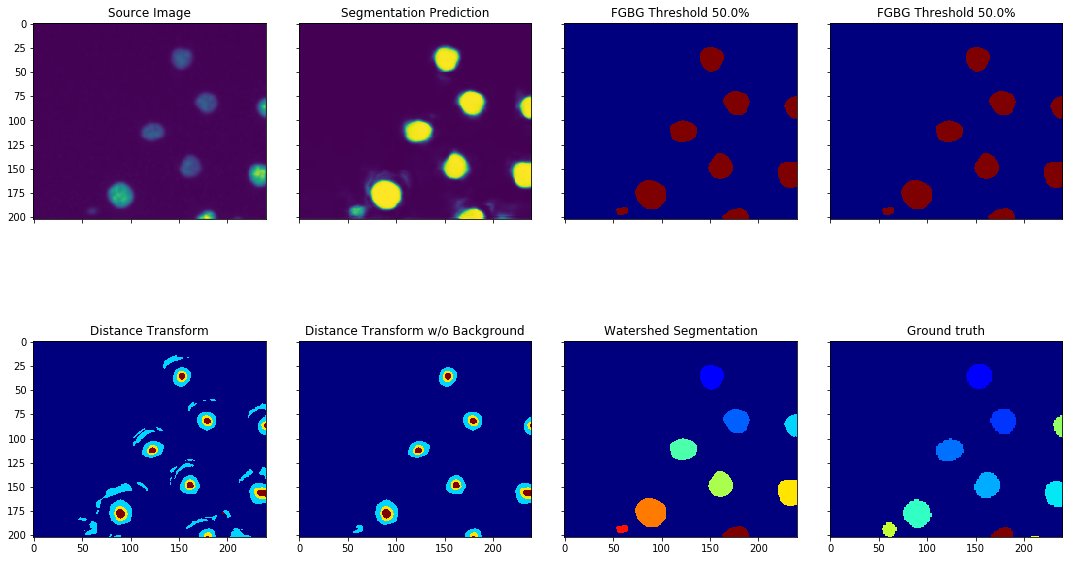

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline

index = 0 #np.random.randint(low=0, high=1)
frame = 11 #np.random.randint(low=0, high=X_test.shape[1])
print('Image number:', index)
print('Frame:', frame)



fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

fg_thresh_90 = test_images_fgbg[..., 1] > 0.5
fg_thresh_90 = np.expand_dims(fg_thresh_90.astype('int16'), axis=-1)
ax[3].imshow(fg_thresh_90[index, frame, ..., 0], cmap='jet')
ax[3].set_title('FGBG Threshold {}%'.format(0.5 * 100))

ax[4].imshow(argmax_images[index, frame, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform')

ax[5].imshow(argmax_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Distance Transform w/o Background')

ax[6].imshow(watershed_images[index, frame, ..., 0], cmap='jet')
ax[6].set_title('Watershed Segmentation')

ax[7].imshow(y_test[index, frame, ..., 0], cmap='jet')
ax[7].set_title('Ground truth')

fig.tight_layout()
plt.show()
# plt.savefig('test.png')

### Make Predictions on ISBI Data for Metrics

In [ ]:
###### FOR ISBI Challenge Datasets

# Define data to load (raw images from trk test files)  
RAW_BASE_DIR = '/data/data/ISBI_Tracking_Challenge/tracks'

raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'ISBI_HeLa_Chal_GT.trks')
raw_trks_MSC  = os.path.join(RAW_BASE_DIR, 'ISBI_MSC_resized_Chal_GT_normalized.trks')
raw_trks_U373 = os.path.join(RAW_BASE_DIR, 'ISBI_U373_Chal_GT.trks')

#raw_trks_files = [raw_trks_HeLa, raw_trks_MSC, raw_trks_U373]
raw_trks_files = [raw_trks_HeLa]

# Define where segmentations will be saved
SEG_BASE_DIR = '/data/track_data/Final_Benchmarks/ISBI_DC_SEG/Watershed/HeLa_segmentations'
                             
DC_seg_HeLa  = os.path.join(SEG_BASE_DIR, 'HeLa/')
DC_seg_MSC   = os.path.join(SEG_BASE_DIR, 'MSC/')
DC_seg_U373  = os.path.join(SEG_BASE_DIR, 'U373/')

#DC_seg_folders = [DC_seg_HeLa, DC_seg_MSC, DC_seg_U373]
DC_seg_folders = [DC_seg_HeLa]

# Define a base file name for the output
BASE_NAME = 'batch_'

In [ ]:
# Instantiate new models for any image size

from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=(None, None, 1),
    last_only=False)

fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_fgbg_model.h5')


watershed_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_conv_filters=32,
    n_dense_filters=128,
    last_only=False,
    input_shape=(None, None, 1))

watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_watershed_model.h5')

In [ ]:
# Run Predict for metric information only

CELL_TYPE_NAME = ['HeLa']
threshold = 0.9

from deepcell import metrics
from skimage.measure import label
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max

import tarfile
import pathlib
import tempfile
import json
import pandas as pd
from io import BytesIO


def load_trks(filename):
    """Load a trk/trks file.

    Args:
        trks_file: full path to the file including .trk/.trks

    Returns:
        A dictionary with raw, tracked, and lineage data
    """
    with tarfile.open(filename, 'r') as trks:

        # numpy can't read these from disk...
        array_file = BytesIO()
        array_file.write(trks.extractfile('raw.npy').read())
        array_file.seek(0)
        raw = np.load(array_file)
        array_file.close()

        array_file = BytesIO()
        array_file.write(trks.extractfile('tracked.npy').read())
        array_file.seek(0)
        tracked = np.load(array_file)
        array_file.close()

    return {'X': raw, 'y': tracked}


Lstats_AllDatasets = []

# Go through each Dataset
for set_num, dataset in enumerate(raw_trks_files):
    # Load the trk file       
    trks = load_trks(dataset)
    raw, tracked = trks['X'], trks['y']
    
    # Create an array for the new annotations
    y_new = np.zeros(tracked.shape)
                
    Lstats_allmovies = []

    # Go through each batch (movie) in each dataset
    for batch_num, movie in enumerate(trks['X']):

        Lstats = []
        # Predict on the raw data
        for frame_num, frame in enumerate(movie):
            
            image = np.expand_dims(frame, axis=0)
             
            test_image = watershed_model.predict(image)[-1]
            test_image_fgbg = fgbg_model.predict(image)[-1]

            # Postprocessing
            # Collapse predictions into semantic segmentation mask        
            max_image = np.argmax(test_image, axis=-1)
            argmax_image = np.expand_dims(max_image, axis=-1)
        
            # threshold the foreground/background
            # and remove background from watershed transform
            fg_thresh = test_image_fgbg[..., 1] > threshold

            fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
            argmax_image_post_fgbg = argmax_image * fg_thresh
        
            # Apply watershed method with the distance transform as seed
            image = fg_thresh[..., 0]
            distance = argmax_image_post_fgbg[..., 0]

            local_maxi = peak_local_max(test_image[..., -1], min_distance=15, 
                                        exclude_border=False, indices=False, labels=image)

            markers = label(local_maxi)
            segments = watershed(-distance, markers, mask=image)
            watershed_image = np.expand_dims(segments, axis=-1)
            
            # Remove small objects from GT for comparison
            small_objects_threshold=50
            GT_image = trks['y'][batch_num, frame_num, :, :, :]
            GT_image = np.expand_dims(GT_image, axis=0)
            GT_image = morphology.remove_small_objects(GT_image.astype('uint16'), min_size=small_objects_threshold)
            
            # Accuracy from metrics package
            filename = CELL_TYPE_NAME[set_num] + BASE_NAME + '{}'.format(batch_num)
            
            m = metrics.Metrics(model_name = filename)
            m.calc_object_stats(GT_image, watershed_image)
            
            # Store results
            y_new[batch_num, frame_num, :, :, :] = watershed_image

            Lstats.append(m.stats)
            
    # Save results of this batch before moving on to the next
    filename = os.path.join(DC_seg_folders[set_num], 'all_batches.trks')
    filename = pathlib.Path(filename)

    with tarfile.open(str(filename), 'w') as trks:
        with tempfile.NamedTemporaryFile() as raw_file:
            np.save(raw_file, raw)
            raw_file.flush()
            trks.add(raw_file.name, 'raw.npy')

        with tempfile.NamedTemporaryFile() as tracked_file:
            np.save(tracked_file, y_new)
            tracked_file.flush()
            trks.add(tracked_file.name, 'tracked.npy')
                
        
        Lstats_allmovies.append(Lstats)
        
    Lstats_AllDatasets.append(Lstats_allmovies)
    
    
#df_HeLa   = pd.concat(Lstats_AllDatasets[0])
df_HeLa = pd.concat([pd.concat(Lstats_AllDatasets[0][0]) , pd.concat(Lstats_AllDatasets[0][1])])


In [ ]:
CELL_TYPE_DF = [df_HeLa]

for cell_type, df in zip(CELL_TYPE_NAME, CELL_TYPE_DF):
    print('\n')
    print(cell_type)
    print('\n')
    # Total number of correct detections and incorrect detections
    correct_det = int(df['correct_detections'].sum())
    incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

    print('Correct Detections: ', correct_det)
    print('Incorrect Detections: ', incorrect_det)
    
    # Total number of splits, merges, and catastrophes
    splits = df['split'].sum()
    merges = df['merge'].sum()
    catastrophes = df['catastrophe'].sum()
    
    print('Splits: ', splits)
    print('Merges: ', merges)
    print('Catastrophes: ', catastrophes)

    # Average Recall, Precision, and Jaccard Index
    recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
    precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
    jaccard = df['jaccard'].mean()

    print('Recall: ', recall)
    print('Precision: ', precision)
    print('Average Jaccard Index: ', jaccard)